<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [鋳造製品の欠陥検出](https://signate.jp/competitions/406)

## Google Colabでの設定

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/MyDrive/Colab Notebooks/01_input.zip" .

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')

In [3]:
TEMP_DIR = "./temp"
INPUT_DIR:str = TEMP_DIR + "/01_input"
TRAIN_DIR:str = INPUT_DIR + "/train_data"
TEST_DIR:str = INPUT_DIR + "/test_data"
ANALYSIS_DIR:str = "/content/drive/MyDrive/Colab Notebooks/03_code-analysis"
MODEL_DIR:str = "/content/drive/MyDrive/Colab Notebooks//04_model"
SUBMISSION_DIR:str = '/content/drive/MyDrive/Colab Notebooks/05_submission'
CHECKPOINT_PATH:str = MODEL_DIR

In [4]:
import shutil
import os

if os.path.isdir(TEMP_DIR):
  shutil.rmtree(TEMP_DIR)

import glob
import zipfile
shutil.unpack_archive('01_input.zip', TEMP_DIR)

## メインコード

In [5]:
import os
import time

"""
from util import Logger, Util
logger = Logger()
"""

from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow
from tensorflow import keras
from tensorflow.keras import models, datasets, layers, applications, optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)

In [6]:
############# Initial Setting #####################################
"""
INPUT_DIR:str = "../01_input"
TRAIN_DIR:str = INPUT_DIR + "/train"
TEST_DIR:str = INPUT_DIR + "/test"
ANALYSIS_DIR:str = "../03_code-analysis"
MODEL_DIR:str = "../04_model"
SUBMISSION_DIR:str = '../05_submission'
CHECKPOINT_PATH:str = MODEL_DIR
"""

IMG_WIDTH:int = 300
IMG_HEIGHT:int = 300
IMG_DEPTH:int = 3
BATCH_SIZE:int = 16 #Default:32

OneHold_or_Kfold : bool = True

fold_num:int = 3 # Default:9
architecture:str = "mobile-net"
#architecture:str = "DenseNet"
#architecture:str = "VGG"
#architecture:str = "efficient-net"

#model_ver:int = 1
epochs:int = 50 # Defalut:50
lr:float = 0.001 # Default:0.001

#################################################################

In [ ]:
# 不要なコード
df = pd.read_csv(INPUT_DIR+"/train.csv")
df
############

,id,target
0,cast_def_0_335.jpeg,0
1,cast_def_0_323.jpeg,0
2,cast_def_0_61.jpeg,0
3,cast_def_0_163.jpeg,0
4,cast_def_0_175.jpeg,0
...,...,...
245,cast_ok_0_346.jpeg,1
246,cast_ok_0_307.jpeg,1
247,cast_ok_0_242.jpeg,1
248,cast_ok_0_184.jpeg,1


In [7]:
#logger.info('start def make_df()')

df = pd.read_csv(INPUT_DIR+"/train.csv")
df['target'] = df['target'].astype(str)

#logger.info('end def make_df()')

## One-Hold法

In [8]:
#logger.info('start def fit_model_one_hold()')

from sklearn.model_selection import train_test_split
train_x, train_y = train_test_split(df, test_size=0.1, stratify=df['target'], random_state=2)

metrics = ['loss', 'accuracy']  # 使用する評価関数を指定
datagen = ImageDataGenerator(
  featurewise_center=False,
  samplewise_center=False,
  featurewise_std_normalization=False,
  samplewise_std_normalization=False,
  zca_whitening=False,
  zca_epsilon=1e-06,
  rotation_range=180,
  width_shift_range=0.05,
  height_shift_range=0.05,
  brightness_range=None,
  shear_range=30.0,
  zoom_range=0.0,
  channel_shift_range=0.0,
  fill_mode='nearest',
  cval=0.0,
  horizontal_flip=True,
  vertical_flip=True,
  rescale=1./255,
  preprocessing_function=None,
  data_format=None,
  validation_split=0.2,
  interpolation_order=1,
  dtype=None
                            )

train_generator = datagen.flow_from_dataframe(
                            dataframe = train_x,
                            directory = TRAIN_DIR,
                            x_col = "id",
                            y_col = "target",
                            target_size=(IMG_WIDTH,IMG_HEIGHT),
                            batch_size=BATCH_SIZE,
                            class_mode='binary',
                            shuffle=False
)

val_generator = datagen.flow_from_dataframe(
                            dataframe = train_y,
                            directory = TRAIN_DIR,
                            x_col = "id",
                            y_col = "target",
                            target_size=(IMG_WIDTH,IMG_HEIGHT),
                            batch_size=BATCH_SIZE,
                            class_mode='binary',
                            shuffle=False
)

Found 225 validated image filenames belonging to 2 classes.
Found 25 validated image filenames belonging to 2 classes.


In [ ]:
#logger.info('start def build_model()')

if architecture == "mobile-net":
    base_model = applications.mobilenet.MobileNet(weights='imagenet',
                                                                    include_top=False,
                                                                    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                                                                  )
elif architecture == "DenseNet":
    base_model = applications.densenet.DenseNet121(weights='imagenet',
                                                                    include_top=False,
                                                                    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                                                                  )
elif architecture == "VGG":
    base_model = applications.vgg19.VGG19(weights='imagenet',
                                                                    include_top=False,
                                                                    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                                                                  )
elif architecture == "efficient-net":
    base_model = applications.efficientnet.EfficientNetB0(weights='imagenet',
                                                                    include_top=False,
                                                                    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                                                                  )

base_model.trainable = False
"""
for layer in base_model.layers[-60:]:
    layer.trainable = True
"""

model = models.Sequential([
base_model,
layers.Flatten(),
layers.Dense(1024, activation='relu'),
layers.Dropout(0.1),
layers.Dense(512, activation='relu'),
layers.Dropout(0.2),
layers.Dense(512, activation='relu'),
layers.Dense(1, activation='sigmoid')
])

adam_low_rate = optimizers.legacy.Adam(learning_rate=lr)

# モデルを構築
model.compile(optimizer=adam_low_rate,
              loss="binary_crossentropy",
              metrics=['accuracy'])

#logger.info('end def build_model()')

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# モデルの概要
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 9, 9, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 1024)              84935680  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

Epoch 1/50
14/14 [==============================] - 40s 3s/step - loss: 14.6106 - accuracy: 0.4976 - val_loss: 39.2821 - val_accuracy: 0.5625
Epoch 2/50
14/14 [==============================] - 35s 3s/step - loss: 16.8151 - accuracy: 0.5120 - val_loss: 2.9331 - val_accuracy: 0.5625
Epoch 3/50
14/14 [==============================] - 35s 3s/step - loss: 4.7587 - accuracy: 0.5933 - val_loss: 2.0373 - val_accuracy: 0.6250
Epoch 4/50
14/14 [==============================] - 37s 3s/step - loss: 2.1854 - accuracy: 0.6746 - val_loss: 0.5560 - val_accuracy: 0.8750
Epoch 5/50
14/14 [==============================] - 38s 3s/step - loss: 1.6663 - accuracy: 0.7368 - val_loss: 3.2916 - val_accuracy: 0.6250
Epoch 6/50
14/14 [==============================] - 36s 3s/step - loss: 1.8358 - accuracy: 0.7512 - val_loss: 1.6844 - val_accuracy: 0.7500
Epoch 7/50
14/14 [==============================] - 36s 3s/step - loss: 1.9774 - accuracy: 0.7703 - val_loss: 2.1769 - val_accuracy: 0.6875
Epoch 8/50
14/14 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/03_code-analysis/metrics_one_hold.png'

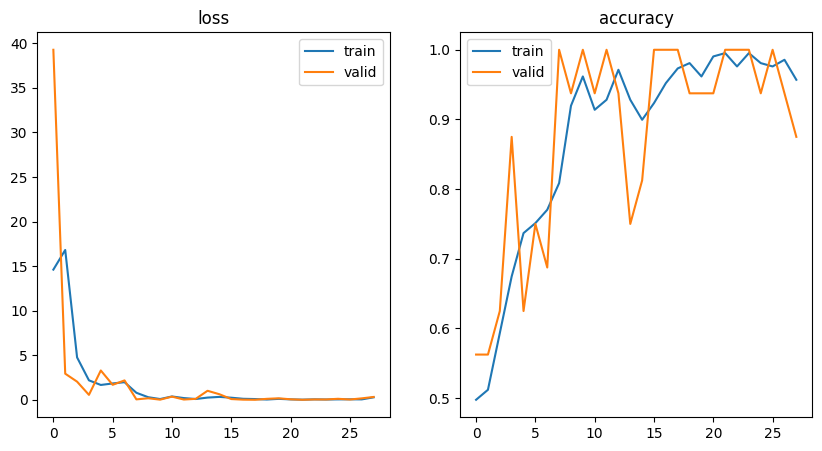

In [ ]:
#logger.info(f'start traing')
# Early stoppingを適用してフィッティング
history = model.fit(train_generator,
                    validation_data = val_generator,
                    steps_per_epoch = train_generator.samples // BATCH_SIZE,
                    validation_steps = val_generator.samples // BATCH_SIZE,
                    verbose=True,
                    #callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1),
                    #           tensorflowkeras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)],
                    callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)],
                    epochs = epochs,
                    workers = 1
)

#logger.info(f'end traing')

# 評価する。
test_loss, test_acc = model.evaluate(val_generator)
#logger.result(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2%}")

model_path = os.path.join(MODEL_DIR+'/cnn_'+architecture+'_OneHold.h5')
model.save(model_path)

plt.figure(figsize=(10, 5))  # グラフを表示するスペースを用意

for i in range(len(metrics)):
  metric = metrics[i]

  plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分ける
  plt.title(metric)

  plt_train = history.history[metric]
  plt_valid  = history.history['val_' + metric]

  plt.plot(plt_train, label='train')
  plt.plot(plt_valid, label='valid')
  plt.legend()

analysis_path = os.path.join(ANALYSIS_DIR+"/metrics_one_hold.png")
plt.savefig(analysis_path)


#logger.info('end def fit_model_one_hold')

import shutil
import glob


#os.makedirs(TEST_DIR+'/dummy/', exist_ok=True)
#for image_path in glob.glob(TEST_DIR + '/*.jpeg'):
#    shutil.move(image_path, TEST_DIR + '/dummy')

#logger.info('start predict by one_hold')

ans = pd.read_csv(INPUT_DIR+"/sample_submission.csv",  header=None)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(ans, TEST_DIR, x_col=0, target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE, class_mode=None, shuffle=False)

prediction = model.predict(test_generator)
prediction = np.where(prediction < 0.5, 0, 1)

ans[1] = prediction

ans.to_csv(path_or_buf = SUBMISSION_DIR+"/submission_.csv", index=False, header=None)
#logger.info('start predict by one_hold')

## 混合行列

In [9]:
#logger.info('start def fit_model_one_hold()')

metrics = ['loss', 'accuracy']  # 使用する評価関数を指定
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
                            dataframe = train_x,
                            directory = TRAIN_DIR,
                            x_col = "id",
                            y_col = "target",
                            target_size=(IMG_WIDTH,IMG_HEIGHT),
                            batch_size=BATCH_SIZE,
                            class_mode='binary',
                            shuffle=False
)

Found 225 validated image filenames belonging to 2 classes.


In [10]:
from tensorflow.keras.models import Model, load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/04_model/cnn_mobile-net_OneHold.h5')

In [15]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = model.predict(train_generator, train_generator.samples // BATCH_SIZE)
y_pred = np.where(Y_pred < 0.5, 0, 1)
print('Confusion Matrix')
print(confusion_matrix(train_generator.classes, y_pred))
print('Classification Report')
print(classification_report(train_generator.classes, y_pred, target_names=None))

15/15 [==============================] - 17s 1s/step
Confusion Matrix
[[134   1]
 [  0  90]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       135
           1       0.99      1.00      0.99        90

    accuracy                           1.00       225
   macro avg       0.99      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225



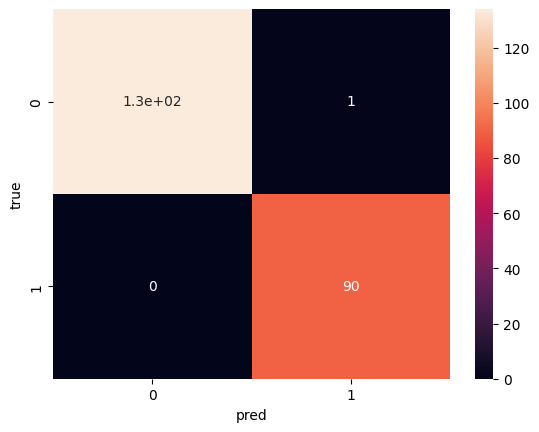

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

swarm_plot = sns.heatmap(confusion_matrix(train_generator.classes, y_pred), annot=True)
plt.xlabel("pred")
plt.ylabel('true')

fig = swarm_plot.get_figure()
fig.savefig(ANALYSIS_DIR+'Confusion_Matrix.png')